In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
import numpy as np

# Load the file (use the exact file path shown in the Files tab)
data = np.load('/content/drive/MyDrive/17_data.npy')

# Display the shape of the data to ensure it loaded correctly
print(data.shape)


(80000, 36, 1000)


In [6]:
# Split into real and imaginary parts
real_part = np.real(data).astype(np.float32)
imaginary_part = np.imag(data).astype(np.float32)

# Check the dtype of the real and imaginary parts
print(real_part.dtype)        # Should output float32
print(imaginary_part.dtype)   # Should output float32

# Verify the shape remains unchanged
print(real_part.shape)
print(imaginary_part.shape)


float32
float32
(80000, 36, 1000)
(80000, 36, 1000)


In [7]:
labels = np.load('/content/drive/MyDrive/17_labels.npy')

In [8]:
labels.shape

(80000,)

In [9]:
X = np.stack([real_part, imaginary_part], axis=-1)

In [10]:
print(X.shape, labels.shape)

(80000, 36, 1000, 2) (80000,)


In [11]:
from sklearn.model_selection import train_test_split

# Split into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)

# Check the shapes
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)



(64000, 36, 1000, 2) (16000, 36, 1000, 2)
(64000,) (16000,)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

def create_ds2ma_model(input_shape, num_channels, filters, units, dropout, learning_rate):
    # Input layer for spectrum data
    inputs = layers.Input(shape=input_shape)

    # Feature extraction: Convolutional layers
    x = layers.Conv2D(filters, kernel_size=(3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters * 2, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    x = layers.Conv2D(filters * 4, kernel_size=(3, 3), activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Flatten the convolutional layer output
    x = layers.Flatten()(x)

    # Fully connected layers with dropout
    x = layers.Dense(units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    # x = layers.Dense(units // 2, activation='relu')(x)
    # x = layers.Dropout(dropout)(x)

    # Output layer: the actions corresponding to the channels to be selected
    outputs = layers.Dense(num_channels, activation='sigmoid')(x)

    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with the given learning rate
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return model

# Hyperparameters
tuned_params = {
    'filters': 32,
    'units': 96,
    'dropout': 0.3,
    'learning_rate': 0.003,
}

# Example usage with tuned parameters
input_shape = (36, 1000, 2)  # For example, 64x64 spectrogram images with 1 channel
num_channels = 1  # For example, 10 possible channels

# Create the model using tuned parameters
model = create_ds2ma_model(
    input_shape,
    num_channels,
    filters=tuned_params['filters'],
    units=tuned_params['units'],
    dropout=tuned_params['dropout'],
    learning_rate=tuned_params['learning_rate']
)

# Display model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36, 1000, 2)]     0         
                                                                 
 conv2d (Conv2D)             (None, 34, 998, 32)       608       
                                                                 
 max_pooling2d (MaxPooling2  (None, 17, 499, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 15, 497, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 248, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 246, 128)       73856 

In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val)
)

Epoch 1/20
2000/2000 [==============================] - 442s 221ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 3663.8997 - val_accuracy: 0.4931
Epoch 2/20
2000/2000 [==============================] - 441s 221ms/step - loss: 0.6931 - accuracy: 0.4990 - val_loss: 3663.8997 - val_accuracy: 0.4931
Epoch 3/20
2000/2000 [==============================] - 437s 219ms/step - loss: 0.6932 - accuracy: 0.4978 - val_loss: 3663.8997 - val_accuracy: 0.4931
Epoch 4/20
2000/2000 [==============================] - 441s 220ms/step - loss: 0.6932 - accuracy: 0.4986 - val_loss: 3663.8997 - val_accuracy: 0.4931
Epoch 5/20
 302/2000 [===>..........................] - ETA: 5:50 - loss: 0.6931 - accuracy: 0.4999

KeyboardInterrupt: 

In [ ]:

# Plot validation accuracy and loss
def plot_training_history(history):
    # Plot validation accuracy
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)


In [ ]:
# Save the best model
model.save('/content/drive/MyDrive/ds2ma_alike/17db/model.h5')

In [ ]:
import os
import numpy as np

# Create a directory to store layer weights
weights_dir = '/content/drive/MyDrive/ds2ma_alike/17db/weights'
os.makedirs(weights_dir, exist_ok=True)

# Save weights of each layer in the model
for i, layer in enumerate(model.layers):
    weights = layer.get_weights()  # Returns a list of NumPy arrays
    if weights:  # Not all layers (like activation layers) have weights
        for j, weight in enumerate(weights):
            # Save each weight array individually
            np.save(os.path.join(weights_dir, f'layer_{i}_weight_{j}.npy'), weight)
            print(f'Saved weights of layer {i} ({layer.name}), weight {j}')


Saved weights of layer 1 (conv2d_3), weight 0
Saved weights of layer 1 (conv2d_3), weight 1
Saved weights of layer 3 (conv2d_4), weight 0
Saved weights of layer 3 (conv2d_4), weight 1
Saved weights of layer 5 (conv2d_5), weight 0
Saved weights of layer 5 (conv2d_5), weight 1
Saved weights of layer 8 (dense_3), weight 0
Saved weights of layer 8 (dense_3), weight 1
Saved weights of layer 10 (dense_4), weight 0
Saved weights of layer 10 (dense_4), weight 1
Saved weights of layer 12 (dense_5), weight 0
Saved weights of layer 12 (dense_5), weight 1


500/500 [==============================] - 26s 53ms/step - loss: 747.4750 - accuracy: 0.5068
Test Loss: 747.4750
Test Accuracy: 0.5068
Predictions: [[0.49837664 0.5016233 ]
 [0.49837664 0.5016233 ]
 [0.49837664 0.5016233 ]
 ...
 [0.49837664 0.5016233 ]
 [0.49837664 0.5016233 ]
 [0.49837664 0.5016233 ]]
Predicted classes: [1 1 1 ... 1 1 1]
Shape of y_val: (16000,)
Confusion Matrix:
[[   0 7890]
 [   1 8109]]


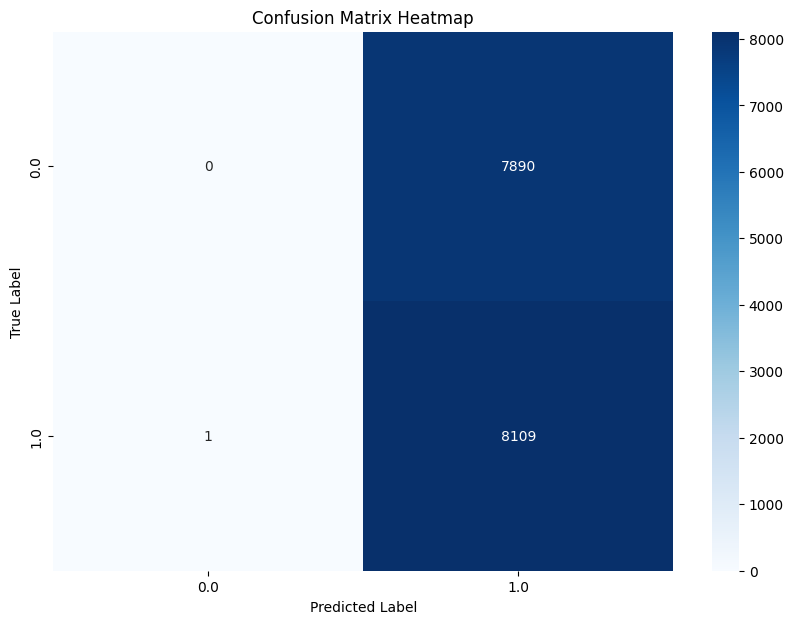

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the saved model
model = load_model('/content/drive/MyDrive/ds2ma_alike/17db/model.h5')

# Step 8: Make predictions on the test data
predictions = model.predict(X_val)

# Step 9: Evaluate the model on the test data
loss, accuracy = model.evaluate(X_val, y_val)

# Print evaluation results
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Optional: Print predictions and predicted classes
predicted_classes = np.argmax(predictions, axis=1)
print("Predictions:", predictions)
print("Predicted classes:", predicted_classes)

# Create a confusion matrix
print("Shape of y_val:", y_val.shape)

# Determine if y_val is one-hot encoded or not
if len(y_val.shape) == 1:  # y_val is 1D
    y_val_classes = y_val  # Use directly
else:  # y_val is 2D (one-hot encoded)
    y_val_classes = np.argmax(y_val, axis=1)

# Create confusion matrix
conf_mat = confusion_matrix(y_val_classes, predicted_classes)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_mat)

# Plotting the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val_classes),
            yticklabels=np.unique(y_val_classes))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [ ]:
!pip install --user --upgrade tensorflow-model-optimization

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Set the policy to 'mixed_float16' for FP16 training
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

# Load the model
model = load_model('/content/drive/MyDrive/ds2ma_alike/17db_g/ds2ma_alike_17db_model.h5')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"FP16 Model Test Loss: {loss:.4f}")
print(f"FP16 Model Test Accuracy: {accuracy:.4f}")

# Save the model
model.save('model_fp16.h5')


ImportError: cannot import name 'experimental' from 'tensorflow.keras.mixed_precision' (/usr/local/lib/python3.10/dist-packages/keras/api/_v2/keras/mixed_precision/__init__.py)